# Materials

A database of pre-defined materials commonly used for QCLs (III-V, II-VI, as well as group IV) are provieded in 

```
aftershoq.materials
```



In [1]:
from aftershoq.materials import *

## Binary compounds

To create a new material simply import it and call it's constructor:

```
GaAs(name = None, T = 0)
```

which takes as parameters an (alternative) name and a lattice temperature:

In [2]:
gaas = GaAs(T=300)
inas = InAs(T=300)
inp = InP(T=300)


> NOTE: Each material has a default temperature (typically 0 or 300 K)! 

The material parameters are found in the scientific literature. The references are given in the documentation string of each material. If you prefer different parameters, you can easily create your own material database or adjust imported materials via the

```
Material.params
```

dictionary.

To see which parameters are currently defined in we can use:

In [3]:
print(f"{'key':10}{str(gaas):>15}{str(inas):>15} {str(inp):>15}")
print("===========================================================")
for key in gaas.params:
    print(f"{key:10}: {gaas.params[key]:15.5g} {inas.params[key]:15.5g} {inp.params[key]:15.5g}")

key                  GaAs           InAs             InP
meff      :        0.062261        0.022051        0.075168
Ec        :               0          -0.892         -0.2854
Eg        :          1.4225         0.35379          1.3529
EX        :          1.8989          1.3698           2.273
EL        :           1.707          1.0698          1.9433
Eso       :           0.341            0.39           0.108
EDel      :               0               0               0
Ep        :            28.8            21.5            20.7
F         :           -1.94            -2.9           -1.31
Valloy    :               0               0               0
ELO       :          0.0376          0.0298          0.0489
ETO       :               0               0               0
eps0      :            12.9            15.1            12.5
epsinf    :           10.89            12.3            9.61
ac        :           -7.17           -5.08              -6
acDel     :               0               0

# Alloys

Alloys are created by combining two binary (or ternary) compounds using bowing parameters (```C```) and the composition ```x```, defined as the relatice concentration of the first element specified.

Below, no bowing paramters are specified and so linear interpolation is used for all parameters.

In [4]:
alas = AlAs(T=300)

algaas = Material(name = "AlGaAs", mat1 = alas, mat2 = gaas, x = 0.15)
print(f'meff = {algaas.params["meff"]:0.3}, Ec = {algaas.params["Ec"]:0.3}')

meff = 0.0752, Ec = 0.148


Many alloys also exist in the database (this includes bowing for Ec):

In [5]:
algaas = AlGaAs(x = 0.15, T = 300)
print(f'meff = {algaas.params["meff"]:0.3}, Ec = {algaas.params["Ec"]:0.3}')

meff = 0.0748, Ec = 0.125


The alloy composition can be updated by:

In [6]:
algaas.updateAlloy(x=0.25)
print(f'meff = {algaas.params["meff"]:0.3}, Ec = {algaas.params["Ec"]:0.3}')

meff = 0.0822, Ec = 0.208


# Strain and band offsets

Strain is calculated using model-solid theory (van de Walle) for each compound as defined with respect to a substrate material. Each material also has a default substrate:

In [7]:
print(algaas.substrate)

GaAs


The strain is calculated using the
```
Material.calcStrain()
```
method, which updates the band structure parameters according to the strain level.

The critical layer thickness is also estimated (following Matthews and Blakeslee 1974) using
```
Material.hcrit()
```

Note that this seems to be significantly underestimated in the current implementation!

In [8]:
alinas = AlInAs(x = 0.60, T = 0)
print(f"Substrate: {alinas.substrate}")
print(f'Unstrained Ec = {alinas.params["Ec"]:0.6}')
alinas.calcStrain()
print(f'Strained Ec = {alinas.params["Ec"]:0.6}')
      
hc = alinas.hcrit()
print(f"The critical layer thickness is {hc:3.2f} Å")

Substrate: InP
Unstrained Ec = 0.246392
Strained Ec = 0.192242
The critical layer thickness is 120.02 Å


## Band offsets

A crucial parameter for subband engineering is the conduction band offset (CBO) between two (or more) semiconductor alloys. For lattice matched materials, such as GaAs/AlGaAs on GaAs or InGaAs/AlInAs on InP, these are well known:

CBO of In0.53Ga0.47As / Al0.48In0.52As on InP is 517.8423799999999 meV.


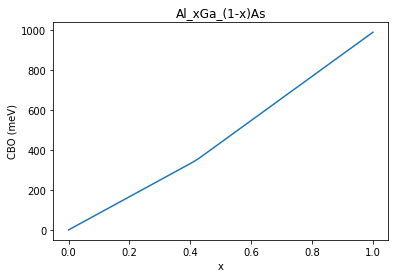

In [59]:
from matplotlib import pyplot as pl
import numpy as np

x = np.linspace(0,1)

well = GaAs(T=300)
barrier = AlGaAs(T=300, x = 0)
dEc = []

for xx in x:
    barrier.updateAlloy(xx)
    dEc.append(barrier.params['Ec'] - well.params['Ec'])

pl.plot(x, np.array(dEc)*1000)
pl.xlabel('x')
pl.ylabel("CBO (meV)")
pl.title('Al_xGa_(1-x)As')

well = InGaAs()
barrier = AlInAs()

dEc = barrier.params['Ec']-well.params['Ec']

print(f"CBO of In{well.x}Ga{1-well.x}As / Al{barrier.x}In{1-barrier.x}As on {well.substrate} is {dEc*1000} meV.")

The kink in the plot above is caused by the gap becoming indirect for x > 0.45.



For strained materials it is more complicated, as the strain changes the lattice constants and thereby the effecticve masses and conduction band offsets. Below is a calculation of InGaAs/AlGaAs on InP, with and without strain effects:

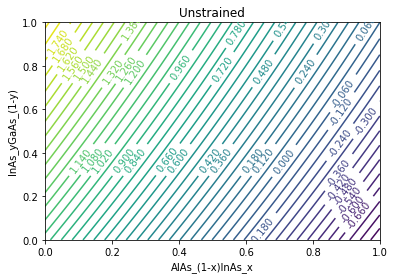

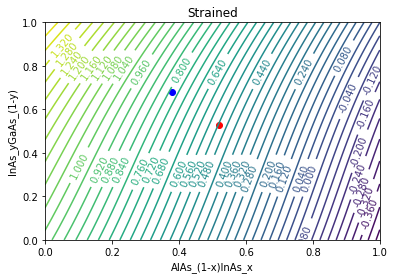

In [58]:
def CBO(well, barrier, strain = True, model = 1):
    x = np.linspace(0,1)
    y = np.linspace(0,1)
    dEc = []
    for xx in x:
        row = []
        well.strained = False # this makes updataAlloy not call calcStrain()
        well.updateAlloy(xx)
        if strain: 
            if model == 1:
                well.calcStrain(meff_bands=2)
            elif model == 2:
                well.calcStrain()
        for yy in y:
            barrier.updateAlloy(yy)
            if strain: barrier.calcStrain()
            row.append(barrier.params['Ec'] - well.params['Ec'])
            #row.append(yy)
        dEc.append(row)
        
    pl.figure()
    CS = pl.contour(1-np.array(x),y,dEc,50)
    pl.clabel(CS)
    pl.ylabel(f'{well.mat1}_y{well.mat2}_(1-y)')
    pl.xlabel(f'{barrier.mat1}_(1-x){barrier.mat2}_x')
    if strain: 
        if model==2:
            pl.title('Sugawara')
        else:
            pl.title('Strained')
    else: 
        pl.title('Unstrained')
    return dEc

dEc = CBO(InGaAs(), AlInAs(), strain = False)
dEc = CBO(InGaAs(), AlInAs(), strain = True)
pl.scatter(0.52,0.53,c='red')
pl.scatter(0.38,0.68,c='blue')

Here, the strain effects are included using model-solid theory by Van the Walle [ Phys. Rev. B 39, pp. 1871-1883 (1989)], or equivalently [Suragawa Phys. Rev. B 48 1993]. The red dot shows the lattice matched composition with DEc ≈ 520 meV, and the blue dot that of the first strain-compenstated design (c.f. Fig. 8.7 of [Quantum Cascade Lasers, J. Faist, Oxford Univ. Press 2013] and thesis of Tobias Gresch (ETH Zürich 2009) ).
## Effective mass
The effect on the effective mass can be seen below for InGaAs:

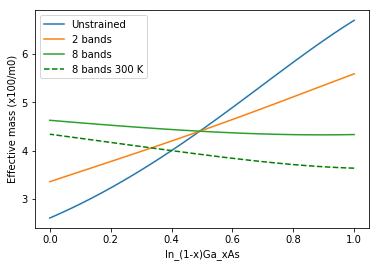

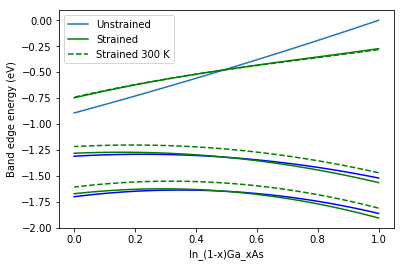

In [61]:
def meff(x, mat, strain=True, model = 1):
    params = []
    for xx in x:
        mat.strained=False # this makes updataAlloy not call calcStrain()
        mat.updateAlloy(xx)
        if strain:
            if model == 1:
                mat.calcStrain(meff_bands=2)
            elif model == 2:
                mat.calcStrain(D=5)
        params.append([mat.params["meff"],mat.params["Ec"],mat.params["Eg"],mat.params["Eso"]])
    return np.array(params)
    
x = np.linspace(0,1,50)

mat = InGaAs(T=0)

pars = meff(x,mat,strain = True)
parus = meff(x,mat,strain = False)
parss = meff(x, mat, strain = True, model = 2)
parssRT = meff(x, InGaAs(T=300), strain = True, model = 2)

pl.plot(1-x,parus[:,0]*100,1-x,pars[:,0]*100,1-x,parss[:,0]*100,1-x,parssRT[:,0]*100,'g--')
pl.legend(['Unstrained','2 bands','8 bands','8 bands 300 K'])
pl.xlabel('In_(1-x)Ga_xAs')
pl.ylabel('Effective mass (x100/m0)')
pl.figure()
pl.plot(1-x,parus[:,1],1-x,parss[:,1],'g',1-x,parssRT[:,1],'g--')
pl.plot(1-x,parus[:,1]-parus[:,2],'b',1-x,parss[:,1]-parss[:,2],'g',1-x,parssRT[:,1]-parssRT[:,2],'g--')
pl.plot(1-x,parus[:,1]-parus[:,2]-parus[:,3],'b')
pl.plot(1-x,parss[:,1]-parss[:,2]-parss[:,3],'g')
pl.plot(1-x,parssRT[:,1]-parssRT[:,2]-parssRT[:,3],'g--')
pl.legend(['Unstrained','Strained','Strained 300 K'])
pl.xlabel('In_(1-x)Ga_xAs')
pl.ylabel('Band edge energy (eV)')
pl.show()

As can be seen in the first plot, the change in effective mass is much smaller in the presence of strain, and experiences a significant shift with temperature.

The second plot shows the band edges for the conduction band, effective valence band, and split-off hole band, respectively for decreasing energy.

# Save and load

Materials can also be saved and loaded in xml format using the

```
Material.save()
```
and the (static)
```
loaded_mat = Material.load()
```
methods.

# Appendix: Calculation of strained effective mass

Taking very similar parameters to Sugawara et al. the calculation below shows the resulting effective mass for strained InGaAs on InP. Here, for D=0, we observe a rahther large deviation from Fig. 3a in Surawaga et al.

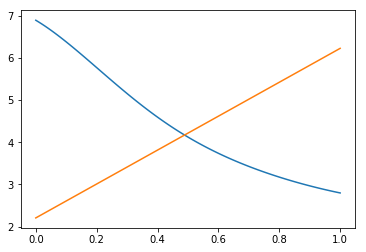

In [54]:
mat = InGaAs()
mat.mat2.params["ac"] = -8.46
mat.mat1.params["ac"] = -6.0
mat.mat2.params["c11"] = 0.8329
mat.mat1.params["c11"] = 1.188
mat.mat2.params["c12"] = 0.4526
mat.mat1.params["c12"] = 0.538
x = np.linspace(0,1,100)
a = mat.mat1.params["lattconst"]*x + mat.mat2.params["lattconst"]*(1-x)
meff = mat.mat1.params["meff"]*x + mat.mat2.params["meff"]*(1-x)
Eg = mat.mat1.params["Eg"]*x + mat.mat2.params["Eg"]*(1-x) - x*(1-x)*0.446
c11 = (mat.mat1.params["c11"]*a[0]*x + mat.mat2.params["c11"]*a[-1]*(1-x) )/a
c12 = (mat.mat1.params["c12"]*a[0]*x + mat.mat2.params["c12"]*a[-1]*(1-x) )/a
ac = mat.mat1.params["ac"]*x + mat.mat2.params["ac"]*(1-x)
bs = mat.mat1.params["bs"]*x + mat.mat2.params["bs"]*(1-x)
delta = mat.mat1.params["Eso"]*x + mat.mat2.params["Eso"]*(1-x)

epsII = (mat.substrate.params["lattconst"]-a)/a

Pe = 2*ac*(c11-c12)/c11*epsII
Qe = -bs*(c11 + 2*c12)/c11*epsII

A = delta + Qe
B = np.sqrt(delta**2 + 2.*Qe*delta+9.*Qe**2)
C = np.sqrt(2.*B*(B-A))

alpha = 2.*np.sqrt(2)*np.abs(Qe)/C
beta = (A-B)*np.abs(Qe)/C/Qe
D = 0

P2 = 0.5*(1/meff - (1+D))*Eg*(Eg + delta)/(Eg + 2./3.*delta)

ESO = -Pe + 0.5*(Qe - delta - np.sqrt(delta**2 + 2.*delta*Qe + 9*Qe**2))
ELH = -Pe + 0.5*(Qe - delta + np.sqrt(delta**2 + 2.*delta*Qe + 9*Qe**2))


inv = (1+D) + 2.*P2/3.*((np.sqrt(2.)*alpha - beta)**2/(Eg + Pe - ELH) + (np.sqrt(2.)*beta + alpha)/(Eg + Pe - ESO))

pl.plot(1-x,1./inv*100,1-x,meff*100)
#pl.plot(1-x,Eg)
#pl.plot(1-x,alpha,1-x,beta,1-x,alpha**2+beta**2)
#pl.plot(1-x,P2)
#pl.ylim((5,15))
#pl.xlim((0.3,0.6))